In [3]:
import time
import datetime

import requests
import os

import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

import fbprophet
from prophet import Prophet

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

os.listdir()

class Crypto():
    
    def __init__(self, crypto, historic_date, lst_of_cryps=None, days=None):
        self.crypto = crypto
        self.historic_date = historic_date
        self.lst_of_cryps = lst_of_cryps
        self.days=days
    
    def find_crypto_stats(self): 

        cryp_req = requests.get(f"https://api.coingecko.com/api/v3/coins/{self.crypto}").json()

        if('error' in cryp_req):
            print("Crypto not found in coingeck.api")
        else:

            for stat in [cryp_req]: 
                # for each statistic (iteration) in our crypto request
                print("\033[1mLoading " +stat['name']+" stats......\033[0m\n")
                # print name of crypto and loading stats
                time.sleep(2)
                try:
                    # print cryptos current price
                    print("\033[1m"+stat['name']+": $"+str(stat["market_data"]["current_price"]["usd"])+'\033[0m')
                    # prints cryptos symbol
                    print(str(self.crypto)+"'s symbol is -- "+stat['symbol']) 
                    # print cryptos hashing algorithm
                    print(stat['symbol']+" uses a "+stat['hashing_algorithm']+" hashing algorithm.") 
                    # prints market cap and total vol
                    print("Market cap -- "+str(stat['market_data']['market_cap']['usd'])+"      Volume -- "+str(stat['market_data']['total_volume']['usd'])) 
                    # market cap rank and dev score
                    print("Market cap rank -- "+str(stat['market_cap_rank'])+"       Developer score -- "+str(stat['developer_score'])) 
                    # subreddit url
                    print(stat['name']+"s official subreddit -- "+stat['links']['subreddit_url']) 

                except TypeError:
                    pass

                print(f"\033[1m\n\nPast Subreddit Details: ({self.historic_date})\033[0m")

                # request for the historic price on specified day using cryptos id
                coin_hist_req = requests.get("https://api.coingecko.com/api/v3/coins/"+ str(stat['id'])+"/history?date="+str(self.historic_date)).json() 
                

                for past_detail in [coin_hist_req]:
                    
                    # print average subreddit users
                    print("Average posts per 48h -- "+str(past_detail['community_data']['reddit_average_posts_48h'])) 
                    # average comments per 48h
                    print("Average comments per 48h -- "+str(past_detail['community_data']['reddit_average_comments_48h'])) 
                    # total subreddit subscribers
                    print('Total subs -- '+str(past_detail['community_data']['reddit_subscribers'])) 

                    # repository data
                    print('\n\n\033[1mRepos data:\033[0m\n'+'Total issues -- '+str(past_detail['developer_data']['total_issues'])+ "      Closed Issues -- "+str(past_detail['developer_data']['closed_issues'])) 

                    # historic price
                    print("\n\n\033[1mHistoric:\033[0m")
                    print(stat['name']+"s price on "+self.historic_date+" -- $"+str(past_detail['market_data']['current_price']['usd'])) 
    
                # requests to get more info on ticker using id
                ticker_request = requests.get("https://api.coingecko.com/api/v3/coins/"+stat['id']+"/tickers").json() 
                for ticker in [ticker_request['tickers']]: 
                    # print the tickers trust score
                    print("\n\033[1mTicker Details:\033[0m \n"+stat['name']+" trust score: "+ticker[0]['trust_score']) 
                    # print the bid-ask spread
                    print("Bid-ask spread: "+str(ticker[0]['bid_ask_spread_percentage'])+"%") 
                    print("Last traded at -- "+ticker[0]['last_traded_at'])
                    print("Trade URL -- "+ticker[0]['trade_url']+"\n\n")

                market_chart_req = requests.get("https://api.coingecko.com/api/v3/coins/"+stat['id']+"/market_chart?vs_currency=usd&days=14").json()
                rev_prices = []
                for price in reversed(market_chart_req['prices']):
                    rev_prices.append(price[1])
                df = pd.DataFrame({'Price (USD)':rev_prices})
                print("\033[1m"+stat['name']+" market chart: \033[0m\n")
                display(df.head(24)) 

                # crypto description
                print("\n\n\033[1mDescription\033[0m: \n"+stat['description']['en']) 




    def evaluate_crypto(self, start_d, months, alpha):
        
        print(f"\033[1mLoading {self.crypto} evaluation...\033[0m\n")
        time.sleep(2)
        
        splt = start_d.split('-')
        start_date = datetime.datetime(int(splt[0]),int(splt[1]),int(splt[2]))
        end_date = datetime.datetime(int(splt[0]),int(splt[1])+1,int(splt[2]))

        month_df = pdr.get_data_yahoo('btc-usd',start=start_date,end=end_date)['Adj Close'].reset_index()
        
        month_df['pct_chg'] = month_df['Adj Close'].pct_change()
        
        perc_chg = month_df['pct_chg'].mean()
        
        avg_mk = month_df['Adj Close'].mean()
        
        
        print(f'''Average Market Price over past {(end_date-start_date).days} days:\n \033[1m${avg_mk:.2f}\033[0m''')
        print(f'''Average percentage change over past {(end_date-start_date).days} days:\n \033[1m{perc_chg:.5f}%\033[0m''')
        
        if perc_chg > alpha:
            if perc_inc > 0:
                print(f'''\033[1mAverage percentage change ({perc_inc}%) is > your desired alpha ({alpha}%)\033[0m''')
        else:
            print(f'''\n\033[1mAverage % change is < your desired alpha({alpha}%)\033[0m''')
        
            
    def several_crypto_stats(self):
        
        if self.lst_of_cryps == None:
            pass
        else:
            for coin in self.lst_of_cryps:
                self.crypto = coin
                self.find_crypto_stats()
#                 inst = Crypto(coin, self.historic_date)
#                 inst.find_crypto_stats()
                print("\n\n\n\n")
                
                
    def see_price_in_currency(self):
        
        cur_and_price = []
        currencies = []  
        
        price_req = requests.get("https://api.coingecko.com/api/v3/coins/"+str(self.crypto)).json()
        
        for num in [price_req]:
            cur_and_price.append((num['market_data']['current_price']))
            
        for i in cur_and_price: 
            for key, val in i.items():
                currencies.append(key)
                
        print("list of currencies: "+str(currencies))
        for num in [price_req]:
            curr = input("What currency would you like to see "+self.crypto+" in?\n")
            print("\nPrice in "+curr+": \033[1m"+str(num["market_data"]["current_price"][curr])+"\033[0m")
        
    
    def prophet_model(self):
        
        cryp_ = requests.get("https://api.coingecko.com/api/v3/coins/"+str(self.crypto)+"/market_chart/range?vs_currency=usd&from=1231039220&to=1650520800").json()
        utc_ls = []
        val_ls = []
        for key, val in cryp_['prices']:
            utc_ls.append(key)
            val_ls.append(val)

        df = pd.DataFrame({'ds':utc_ls,'y':val_ls})

        df['ds'] = df['ds'].apply(lambda x: datetime.datetime.utcfromtimestamp(int(x)/1000).strftime('%Y-%m-%d'))
        df['ds'] = pd.to_datetime(df['ds'])



        priors = [0.0015, 0.015]
        prophets, labels = [], []
        for prior in priors:
            prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
            prophet.fit(df)
            prophets.append(prophet)
            labels.append(r"CP Prior = " + str(prior))

        forecasts = []
        for prophet in prophets:
            forecast = prophet.make_future_dataframe(periods=self.days, freq="D")
            forecast = prophet.predict(forecast)

            forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
            forecasts.append(forecast)


        output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
        output = output.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)

        output = output.set_index('Date')
        
        return output,df,labels

    def plot_cp_prediction(self):
        
        print("\033[1mMultiple prophet predictions using priors\033[0m")

        plot_data, df, labels = self.prophet_model()

        fig, ax = plt.subplots(1, 1, figsize=(14, 7))

        ax.plot(plot_data.index, 
                plot_data["yhat_x"], 
                label=labels[0],
                color='tab:red'
               )

        ax.fill_between(plot_data.index, 
                        plot_data["yhat_upper_x"], 
                        plot_data["yhat_lower_x"], 
                        alpha=0.5, 
                        edgecolor = "k", 
                        color='tab:red'
                       )

        ax.plot(plot_data.index, 
                plot_data["yhat_y"], 
                "r", 
                label=labels[1],
                color='tab:blue'
               )

        ax.fill_between(plot_data.index, 
                        plot_data["yhat_upper_y"], 
                        plot_data["yhat_lower_y"], 
                        alpha=0.5, 
                        edgecolor = "k",
                        color='tab:blue'
                       )

        ax.plot(df['ds'], df['y'], 
                color="k", 
                linewidth=3, 
                label=r"Bitcoin Actual Price"
               )

        plt.legend(loc="upper left")
        plt.ylabel("Price", size=13)
        plt.xlabel("Date", size=13)
        plt.title("Priors Model Predictions", size=16)
        plt.show()
        
        
    def prophet_prediction_plot(self):
        
        print("\033[1mDefault Prophet Prediction\033[0m")
        
        x,df,_ = self.prophet_model()
        
        stock_prophet_df = Prophet()

        stock_prophet_df.fit(df)

        stock_future_df = stock_prophet_df.make_future_dataframe(periods=self.days, freq = 'D')

        stock_forecast = stock_prophet_df.predict(stock_future_df)

        fig, ax = plt.subplots(figsize=(12,6))

        stock_plot = stock_prophet_df.plot(stock_forecast,ax=ax)

        ax.axhline(max(stock_forecast['yhat']),color='r',lw=1,ls='--')

        idmx = stock_forecast['yhat'].idxmax()

        max_date = (stock_forecast['ds'].loc[idmx].normalize().strftime('%Y-%m-%d'))
        max_val = (stock_forecast['yhat'].loc[idmx])

        ax.text(x=stock_forecast['ds'].loc[idmx]-datetime.timedelta(days=1400),
                y=stock_forecast['yhat'].loc[idmx]+.12,
                s=f'Max Predicted Value ({max_val:.2f}) on: {max_date}', 
                size='large')

        ax.set_title(f"{self.crypto.capitalize()} Prophet Default Prediction", size=18)
        ax.set_xlabel("Date",size=14)
        ax.set_ylabel("Value",size=14)
        
        ax
        
    
    def ticker_plot(self):
        
        print("\033[1mAll-Time Ticker Plot\033[0m")
        
        x,df,_ = self.prophet_model()
        
        df['d_shift'] = df['y'].loc[1:]
        
        ls = df['d_shift'].to_list()
        
        ls.insert(0,np.nan)
        ls.pop()
        
        df['shifted'] = ls
        
        df['dif'] = df['shifted'] - df['d_shift']
        
        df['label'] = df['dif'].apply(lambda x: 'increase' if x < 0 else 'decrease')
        
        
        tk = px.line(data_frame=df,x='ds',y='y',width=1000, height=600,color='label',
                labels={
                     "ds":"Date",
                     "y":"Price",
                 },
                color_discrete_map={
                "increase": "green", "decrease": "red"
            },         
#             template="simple_white"
            )
        
        tk.update_layout(
            title={
            'text': f"{self.crypto.capitalize()} Market Chart",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'}
        )
        
        
        # adds rangeslider (https://towardsdatascience.com/visualization-with-plotly-express-comprehensive-guide-eb5ee4b50b57)
        tk.update_xaxes(rangeslider_visible=True)
        
        tk.show()
        
        
        
        def convert_to_utc(self, date_dd_mm_yy):
            
            return round(time.mktime(datetime.datetime.strptime(date_dd_mm_yy, "%d/%m/%Y").timetuple()))
        
        
        
            

    # Class Crypto ( "crypto", historic_date(dd-mm-yyyy), list_of_cryptos(['bitcoin','cardano']), days_predict(365) )

#     ---------------------------------------------------------------------------------------------------------------------
    
    # def find_crypto_stats()
    
    ## this function will essentially return the current cryptos price, symbol, hashing algorithm, 
    ## market cap / volume, subreddit details, repos data, historic details, ticker details, market_chart,
    ## and a short desciption of the crypto (such as who created it, why?, etc)
    
#    ---------------------------------------------------------------------------------------------------------------------




list of currencies: ['aed', 'ars', 'aud', 'bch', 'bdt', 'bhd', 'bmd', 'bnb', 'brl', 'btc', 'cad', 'chf', 'clp', 'cny', 'czk', 'dkk', 'dot', 'eos', 'eth', 'eur', 'gbp', 'hkd', 'huf', 'idr', 'ils', 'inr', 'jpy', 'krw', 'kwd', 'lkr', 'ltc', 'mmk', 'mxn', 'myr', 'ngn', 'nok', 'nzd', 'php', 'pkr', 'pln', 'rub', 'sar', 'sek', 'sgd', 'thb', 'try', 'twd', 'uah', 'usd', 'vef', 'vnd', 'xag', 'xau', 'xdr', 'xlm', 'xrp', 'yfi', 'zar', 'bits', 'link', 'sats']
What currency would you like to see bitcoin in?
usd

Price in usd: 39461




Loading Bitcoin stats......

Bitcoin: $39461
bitcoin's symbol is -- btc
btc uses a SHA-256 hashing algorithm.
Market cap -- 751063896511      Volume -- 47549295318
Market cap rank -- 1       Developer score -- 98.95
Bitcoins official subreddit -- https://www.reddit.com/r/Bitcoin/


Past Subreddit Details: (12-09-2020)
Average posts per 48h -- 7.273
Average comments per 48h -- 213.818
Total subs -- 1636833


Repos data:
Total issues -- 5684      Closed Issues -- 5135



,Price (USD)
0,39369.912333
1,39413.396613
2,39919.474676
3,40325.363427
4,40429.023203
5,40575.765094
6,40448.507389
7,40320.944960
8,40416.520106
9,40665.953740




Description: 
Bitcoin is the first successful internet money based on peer-to-peer technology; whereby no central bank or authority is involved in the transaction and production of the Bitcoin currency. It was created by an anonymous individual/group under the name, Satoshi Nakamoto. The source code is available publicly as an open source project, anybody can look at it and be part of the developmental process.

Bitcoin is changing the way we see money as we speak. The idea was to produce a means of exchange, independent of any central authority, that could be transferred electronically in a secure, verifiable and immutable way. It is a decentralized peer-to-peer internet currency making mobile payment easy, very low transaction fees, protects your identity, and it works anywhere all the time with no central authority and banks.

Bitcoin is designed to have only 21 million BTC ever created, thus making it a deflationary currency. Bitcoin uses the <a href="https://www.coingecko.com/en

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -81.579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4822.11    7.3348e-06       2172.31           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       4825.15   1.41087e-05       1902.31   7.541e-09       0.001      213  LS failed, Hessian reset 
     199       4829.32   0.000192378       1999.04           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       4839.98     0.0034047       2403.53   1.218e-06       0.001      380  LS failed, Hessian reset 
     296       4845.48   9.62575e-05       2318.73   3.489e-08       0.001      531  LS failed, Hessian reset 
     299        4845.6    2.2438e-05       1988.89      0.1656           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -81.579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6232.49     0.0121027        568.32           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       6247.97   0.000808587       528.587   2.575e-06       0.001      224  LS failed, Hessian reset 
     163       6251.04   0.000767589        416.62   4.016e-06       0.001      278  LS failed, Hessian reset 
     199       6254.18    0.00185037       330.212           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       6254.75   0.000930409       288.736   3.885e-06       0.001      370  LS failed, Hessian reset 
     299       6255.31    2.3352e-06       274.776      0.4187      0.1279      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/7z/lks_pjcd1fv91v27m8gf5l1h0000gn/T/ipykernel_81206/3409282641.py:230: UserWarning:

color is redun

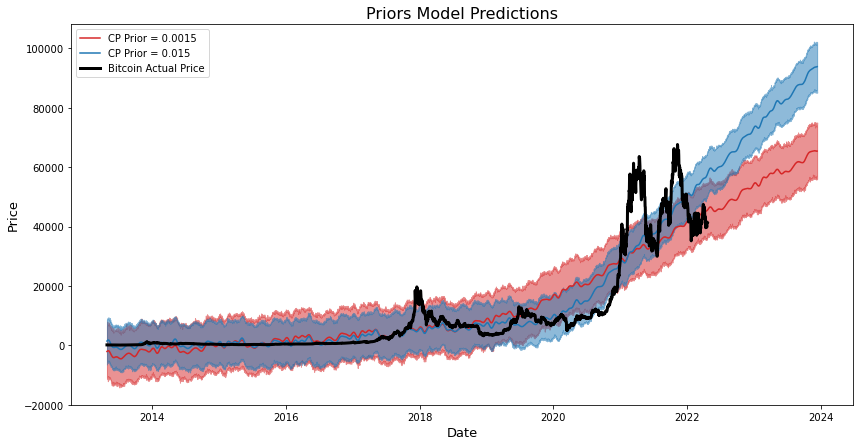





Default Prophet Prediction


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -81.579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4822.11    7.3348e-06       2172.31           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       4825.15   1.41087e-05       1902.31   7.541e-09       0.001      213  LS failed, Hessian reset 
     199       4829.32   0.000192378       1999.04           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       4839.98     0.0034047       2403.53   1.218e-06       0.001      380  LS failed, Hessian reset 
     296       4845.48   9.62575e-05       2318.73   3.489e-08       0.001      531  LS failed, Hessian reset 
     299        4845.6    2.2438e-05       1988.89      0.1656           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -81.579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6232.49     0.0121027        568.32           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       6247.97   0.000808587       528.587   2.575e-06       0.001      224  LS failed, Hessian reset 
     163       6251.04   0.000767589        416.62   4.016e-06       0.001      278  LS failed, Hessian reset 
     199       6254.18    0.00185037       330.212           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       6254.75   0.000930409       288.736   3.885e-06       0.001      370  LS failed, Hessian reset 
     299       6255.31    2.3352e-06       274.776      0.4187      0.1279      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/micha

Initial log joint probability = -81.579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6422.89   0.000994425        167.41      0.7697      0.7697      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       6433.87    0.00120684       347.932   9.023e-06       0.001      265  LS failed, Hessian reset 
     199       6435.71    0.00812157        130.82           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       6437.46    0.00022655       155.551   8.852e-07       0.001      350  LS failed, Hessian reset 
     282       6440.13   0.000199335        145.05   1.443e-06       0.001      459  LS failed, Hessian reset 
     299       6441.07    0.00378002       136.515           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.







All-Time Ticker Plot


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -81.579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4822.11    7.3348e-06       2172.31           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       4825.15   1.41087e-05       1902.31   7.541e-09       0.001      213  LS failed, Hessian reset 
     199       4829.32   0.000192378       1999.04           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       4839.98     0.0034047       2403.53   1.218e-06       0.001      380  LS failed, Hessian reset 
     296       4845.48   9.62575e-05       2318.73   3.489e-08       0.001      531  LS failed, Hessian reset 
     299        4845.6    2.2438e-05       1988.89      0.1656           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -81.579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6232.49     0.0121027        568.32           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       6247.97   0.000808587       528.587   2.575e-06       0.001      224  LS failed, Hessian reset 
     163       6251.04   0.000767589        416.62   4.016e-06       0.001      278  LS failed, Hessian reset 
     199       6254.18    0.00185037       330.212           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       6254.75   0.000930409       288.736   3.885e-06       0.001      370  LS failed, Hessian reset 
     299       6255.31    2.3352e-06       274.776      0.4187      0.1279      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michaelm/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



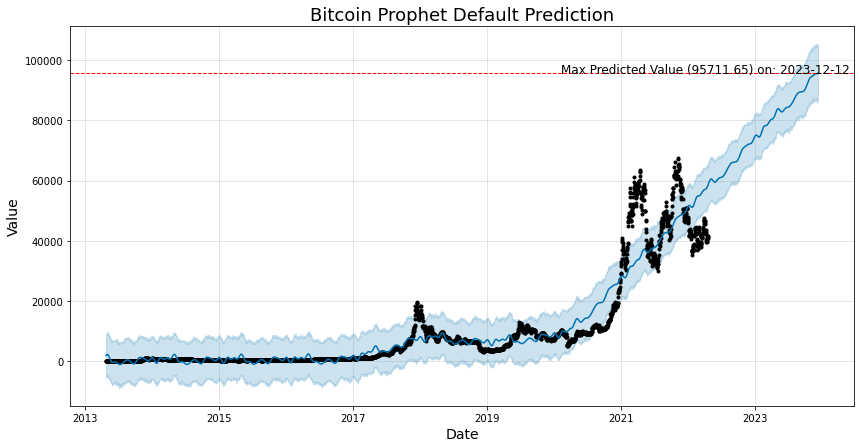

In [5]:
def main():
    inst = Crypto(crypto='bitcoin', 
                  historic_date='12-09-2020', 
                  lst_of_cryps=['bitcoin', 'cardano', 'ethereum', 'litecoin'],
                  days=600
                 )
    
    inst.see_price_in_currency()
    time.sleep(1)
    print('\n\n\n')
    inst.find_crypto_stats()
    time.sleep(1)
    print('\n\n\n')
    inst.evaluate_crypto('2022-2-10',1,.12)
    time.sleep(1)
    print('\n\n\n')
    inst.plot_cp_prediction()
    time.sleep(1)
    print('\n\n\n')
    inst.prophet_prediction_plot()
    time.sleep(1)
    print('\n\n\n')
    inst.ticker_plot()
    time.sleep(1)
    
    
    
    

if __name__ == '__main__':
    main()